Target variable: Usage_kWh

# About Dataset  
This company produces several types of coils, steel plates, and iron plates. The information on electricity consumption is held in a cloud-based system. The information on energy consumption of the industry is stored on the website of the Korea Electric Power Corporation (pccs.kepco.go.kr), and the perspectives on daily, monthly, and annual data are calculated and shown.  

## Attribute Information:
Date: Continuous: time data taken on the first of the month  
Usage_kWh Industry Energy Consumption: Continuous: kWh  
Lagging Current reactive power: Continuous: kVarh  
Leading Current reactive power: Continuous: kVarh  
CO2: Continuous: ppm  
NSM: Number of Seconds from midnight: Continuous: s  
Week status: Categorical: Weekend, Weekday  
Day of week: Categorical: Sunday, Monday : Saturday  
Load Type: Categorical: Light Load, Medium Load, Maximum Load  

These terms are related to electrical power systems.  

## Industry Knowledge:  
Reactive Power (kVarh): This is the power that oscillates back and forth, not doing any actual work but is necessary for the system to function. It's divided into "lagging" (inductive load) and "leading" (capacitive load).  
Power Factor: This is the ratio of real power (doing actual work) to apparent power (the total power supplied). It's also divided into "lagging" (when current lags behind voltage) and "leading" (when current leads the voltage).  

In short, these terms describe different aspects of how electrical power is used and managed in a power system.  

**Problem:** After recent power optimization efforts, is the company on track to consume less real energy next month?

In [1]:
#Import packages
import math
from ydata_profiling import ProfileReport
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from prophet import Prophet
from prophet.plot import plot, plot_components, plot_cross_validation_metric
from matplotlib import pyplot as plt
from prophet.diagnostics import cross_validation, performance_metrics
from statsmodels.tsa.stattools import adfuller
import itertools
import holidays
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Read in data and filter to only active (real) power and categorical features
df = pd.read_csv("C:/Users/erice/OneDrive/Desktop/Data Society Assessment/Steel_industry_data.csv", header=0)
df = df[['date','Usage_kWh','WeekStatus', 'Day_of_week', 'Load_Type']]
df.head()

,date,Usage_kWh,WeekStatus,Day_of_week,Load_Type
0,01/01/2018 00:15,3.17,Weekday,Monday,Light_Load
1,01/01/2018 00:30,4.00,Weekday,Monday,Light_Load
2,01/01/2018 00:45,3.24,Weekday,Monday,Light_Load
3,01/01/2018 01:00,3.31,Weekday,Monday,Light_Load
4,01/01/2018 01:15,3.82,Weekday,Monday,Light_Load


In [3]:
#Use the profile report of simple EDA
df_profile = ProfileReport(df, title="Data Society Case Study", minimal=True, progress_bar = True, infer_dtypes = False)
df_profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

**EDA:**  
No missing values  
Time needs to be parsed into its sub-components.  
Time is in 15 min increments.  
Real power is right skewed, bi-modal, a single zero record, high variance, and outliers  
Light load is most frequent load type with 52% of observations, followed by medium then maximum load.  
There is one extra monday in the dataset, so there are slightly more occurances of weekdays than weekend when normalized by day  

In [4]:
#In anticipation of a question around day of week occurance (e.g. 2nd tuesdays), I define a function to define it for each date
def dow_occur(day_of_month):
    ret = None    
    if ( day_of_month % 7 == 0 ):
        ret = day_of_month/7
    else:
        ret = (day_of_month//7) + 1
    return ret       

In [5]:
#Break out date/time into its relevant components
df['full_date'] = pd.to_datetime(df['date'], dayfirst=True)
df['base_date'] = pd.to_datetime(df['full_date'].dt.strftime('%Y-%m-%d'))
df['day'] = df['full_date'].dt.day
df['month'] = df['full_date'].dt.month
df['year'] = df['full_date'].dt.year
df['time'] = df['full_date'].dt.time
for i in df.index:
    df.loc[i,'dow_occur'] = int(dow_occur(df.loc[i,'day']))
df1 = df[['full_date', 'base_date', 'month','day', 'time', 'dow_occur','Usage_kWh','WeekStatus', 'Day_of_week', 'Load_Type']]
df1.head()

,full_date,base_date,month,day,time,dow_occur,Usage_kWh,WeekStatus,Day_of_week,Load_Type
0,2018-01-01 00:15:00,2018-01-01,1,1,00:15:00,1.0,3.17,Weekday,Monday,Light_Load
1,2018-01-01 00:30:00,2018-01-01,1,1,00:30:00,1.0,4.00,Weekday,Monday,Light_Load
2,2018-01-01 00:45:00,2018-01-01,1,1,00:45:00,1.0,3.24,Weekday,Monday,Light_Load
3,2018-01-01 01:00:00,2018-01-01,1,1,01:00:00,1.0,3.31,Weekday,Monday,Light_Load
4,2018-01-01 01:15:00,2018-01-01,1,1,01:15:00,1.0,3.82,Weekday,Monday,Light_Load


In [6]:
#Organize columns by their data type. Note: My code is structured to evaluate multiple numerical and categorical features seamlessly
Num_cols = ['Usage_kWh']
Cat_cols = ['WeekStatus', 'Day_of_week', 'Load_Type','month','time','dow_occur']

In [7]:
#Derive my own desriptive statistics of numerical features for illistrative puposed to prove my hunch around outliers
df_n_desc = df1[Num_cols].describe([0.25,0.75])
df_n_desc.loc['Sum',:] = None
df_n_desc.loc['Zeros',:] = None
df_n_desc.loc['Nulls',:] = None
df_n_desc.loc['IQR',:] = None
df_n_desc.loc['Outliers',:] = None
for col in df_n_desc.columns:
    df_n_desc.loc['Sum',col] = df1[col].sum()
    df_n_desc.loc['Sum',col] = len(df1[col].unique())
    df_n_desc.loc['Zeros',col] = df1.loc[df1[col] == 0][col].count()
    df_n_desc.loc['Nulls',col] = df1.loc[df1[col] == None][col].count()
    df_n_desc.loc['IQR',col] = df_n_desc.loc['75%',col] - df_n_desc.loc['25%',col]
    df_n_desc.loc['Outliers',col] = df1.loc[(df1[col]> (df_n_desc.loc['mean',col]+1.5*df_n_desc.loc['IQR',col]))|(df1[col]< (df_n_desc.loc['mean',col]-1.5*df_n_desc.loc['IQR',col]))][col].count()

df_n_desc

,Usage_kWh
count,35040.000000
mean,27.386892
std,33.444380
min,0.000000
25%,3.200000
50%,4.570000
75%,51.237500
max,157.180000
Sum,3343.000000
Zeros,1.000000


In [8]:
print(f'''Outliers represent {round(df_n_desc.loc['Outliers',col]*100/df_n_desc.loc['count',col],2)}% of the data''')
#This indicates some manipulation of the target variable is needed

Outlier represent 4.908675799086758 of the data


In [9]:
#Derive my own desriptive statistics of numerical features by the categorical features
df_c_desc = dict.fromkeys(Cat_cols,dict.fromkeys(Num_cols,0))
for cat in Cat_cols:
    for col in Num_cols:
        #print(f'''{cat} by {col}''')
        temp = df1.groupby(cat)[col].describe()
        temp.loc[:,'Sum'] = df1.groupby(cat)[col].sum()
        temp.loc[:,'Zeros'] = df1.loc[df1[col] == 0].groupby(cat)[col].count()
        temp.loc[:,'Nulls'] = df1.loc[df1[col] == None].groupby(cat)[col].count()
        temp.loc[:,'IQR'] = temp.loc[:,'75%'] - temp.loc[:,'25%']
        for i in temp.index:
            df2 = df1.loc[df1[cat] == i]
            temp.loc[i,'Outliers'] = df2.loc[(df1[col] > 1.5*temp.loc[i,'mean']+1.5*temp.loc[i,'IQR'])|(df1[col] < 1.5*temp.loc[i,'mean']-1.5*temp.loc[i,'IQR'])][col].count()
        df_c_desc[cat][col] = temp
        display(df_c_desc[cat][col].fillna(0))


,count,mean,std,min,25%,50%,75%,max,Sum,Zeros,Nulls,IQR,Outliers
WeekStatus,,,,,,,,,,,,,
Weekday,25056.0,33.624727,35.624802,0.00,3.46,7.60,58.7275,157.18,842501.16,1.0,0.0,55.2675,109.0
Weekend,9984.0,11.732327,19.947867,2.45,3.02,3.46,4.8200,133.42,117135.55,0.0,0.0,1.8000,9942.0


,count,mean,std,min,25%,50%,75%,max,Sum,Zeros,Nulls,IQR,Outliers
Day_of_week,,,,,,,,,,,,,
Friday,4992.0,33.195014,34.706010,2.48,3.53,9.02,57.1300,151.31,165709.51,0.0,0.0,53.6000,28.0
Monday,5088.0,33.143935,35.389079,2.45,3.35,6.28,59.1575,153.14,168636.34,0.0,0.0,55.8075,22.0
Saturday,4992.0,15.919020,23.654466,2.45,3.13,3.74,24.5975,133.42,79467.75,0.0,0.0,21.4675,385.0
Sunday,4992.0,7.545633,14.188620,2.48,2.95,3.20,4.0300,116.78,37667.80,0.0,0.0,1.0800,4966.0
Thursday,4992.0,35.112083,36.415246,2.45,3.53,19.85,59.1200,157.18,175279.52,0.0,0.0,55.5900,25.0
Tuesday,4992.0,34.427614,35.831626,2.48,3.53,9.29,60.2375,151.67,171862.65,0.0,0.0,56.7075,8.0
Wednesday,4992.0,32.254235,35.706382,0.00,3.42,5.85,57.8975,149.18,161013.14,1.0,0.0,54.4775,25.0


,count,mean,std,min,25%,50%,75%,max,Sum,Zeros,Nulls,IQR,Outliers
Load_Type,,,,,,,,,,,,,
Light_Load,18072.0,8.626207,17.906245,0.00,2.9500,3.310,4.03,140.29,155892.81,1.0,0.0,1.0800,18056.0
Maximum_Load,7272.0,59.265314,29.749700,2.92,42.0025,56.630,75.31,151.67,430977.36,0.0,0.0,33.3075,1585.0
Medium_Load,9696.0,38.445394,35.220166,2.52,4.4200,34.435,61.70,157.18,372766.54,0.0,0.0,57.2800,11.0


,count,mean,std,min,25%,50%,75%,max,Sum,Zeros,Nulls,IQR,Outliers
month,,,,,,,,,,,,,
1,2976.0,42.418780,42.015821,3.10,4.64,33.370,75.0600,153.14,126238.29,0.0,0.0,70.4200,0.0
2,2688.0,34.039189,37.213194,2.99,4.18,6.425,63.4000,145.51,91497.34,0.0,0.0,59.2200,4.0
3,2976.0,26.959143,32.197341,2.70,3.38,4.930,48.7400,151.31,80230.41,0.0,0.0,45.3600,76.0
4,2880.0,27.350625,32.373133,2.56,3.28,4.140,53.3600,139.03,78769.80,0.0,0.0,50.0800,22.0
5,2976.0,26.565618,33.936152,2.70,3.13,3.740,51.2375,140.04,79059.28,0.0,0.0,48.1075,71.0
6,2880.0,22.709944,29.345840,2.48,2.99,3.640,42.9575,133.85,65404.64,0.0,0.0,39.9675,103.0
7,2976.0,27.444358,31.287773,2.56,2.95,3.850,52.3500,121.68,81674.41,0.0,0.0,49.4000,12.0
8,2976.0,23.037443,31.293868,2.48,2.81,3.240,45.6200,133.70,68559.43,0.0,0.0,42.8100,122.0
9,2880.0,20.098288,28.189600,2.45,2.77,3.280,37.4450,127.62,57883.07,0.0,0.0,34.6750,145.0


,count,mean,std,min,25%,50%,75%,max,Sum,Zeros,Nulls,IQR,Outliers
time,,,,,,,,,,,,,
00:00:00,365.0,7.977205,16.575635,0.00,2.92,3.53,4.07,104.65,2911.68,1.0,0.0,1.15,365.0
00:15:00,365.0,7.683589,15.085223,2.48,2.92,3.46,3.89,95.90,2804.51,0.0,0.0,0.97,365.0
00:30:00,365.0,8.091534,16.842416,2.48,2.92,3.49,3.96,105.55,2953.41,0.0,0.0,1.04,365.0
00:45:00,365.0,7.727973,15.721292,2.45,2.92,3.42,3.89,104.72,2820.71,0.0,0.0,0.97,365.0
01:00:00,365.0,7.804356,16.467087,2.48,2.88,3.42,3.89,104.94,2848.59,0.0,0.0,1.01,365.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
22:45:00,365.0,8.361041,16.965687,2.52,3.13,3.60,4.21,107.89,3051.78,0.0,0.0,1.08,365.0
23:00:00,365.0,8.048466,15.592917,2.52,3.10,3.60,4.21,105.37,2937.69,0.0,0.0,1.11,365.0
23:15:00,365.0,7.934740,15.781320,2.45,2.95,3.56,4.14,98.35,2896.18,0.0,0.0,1.19,365.0


,count,mean,std,min,25%,50%,75%,max,Sum,Zeros,Nulls,IQR,Outliers
dow_occur,,,,,,,,,,,,,
1.0,8064.0,26.413415,33.617341,0.00,3.17,4.21,49.9300,147.46,212997.78,1.0,0.0,46.7600,223.0
2.0,8064.0,29.011601,35.035433,2.52,3.31,4.79,54.1500,145.30,233949.55,0.0,0.0,50.8400,132.0
3.0,8064.0,28.752529,34.087778,2.48,3.28,4.61,54.2275,153.14,231860.39,0.0,0.0,50.9475,101.0
4.0,8064.0,25.952318,31.143254,2.45,3.17,4.61,47.7400,157.18,209279.49,0.0,0.0,44.5700,198.0
5.0,2784.0,25.700251,32.418627,2.45,3.06,4.00,49.1400,143.82,71549.50,0.0,0.0,46.0800,86.0


We can see that there is some overlap in real power between the load types.  
The average power usage by month is decreasing over time.  
Time of day usage needs to be investiaged further.  

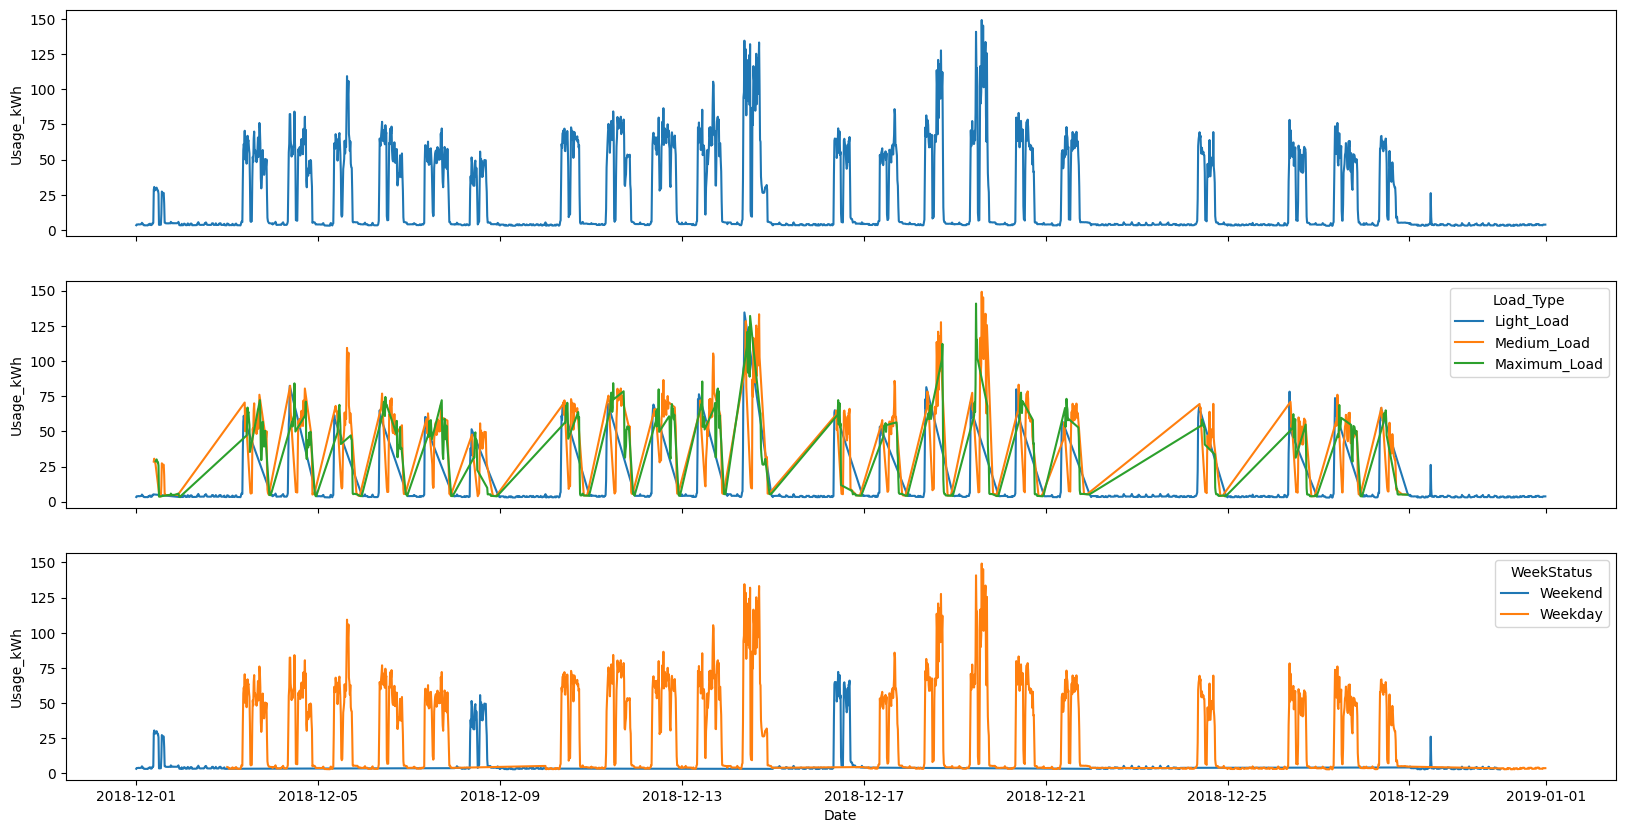

In [10]:
%matplotlib inline
# Visualize the real power usage over time by categorical features
for col in ['Usage_kWh']:#Num_cols:
    fig, axes = plt.subplots(3, 1, sharex=True, figsize=(20,10))
    # We use base date (MDY) as full date is too noisy to visualize for trends 
    sns.lineplot(ax=axes[0], data=df1.loc[df1['month'] == 12], x="full_date", y=col)
    sns.lineplot(ax=axes[1], data=df1.loc[df1['month'] == 12], x="full_date", y=col, hue="Load_Type")
    sns.lineplot(ax=axes[2], data=df1.loc[df1['month'] == 12], x="full_date", y=col, hue="WeekStatus")
    plt.xlabel('Date')
    plt.show()

Here we see the strong daily occilation of real power with a declining trend over time
Maximal and medium load types coincide more at the start of the time window
Most week days have the power usage, and weekends are lower with Sunday having the lowest usage

These trends are consistent when you look at the cross section of load types and DOY

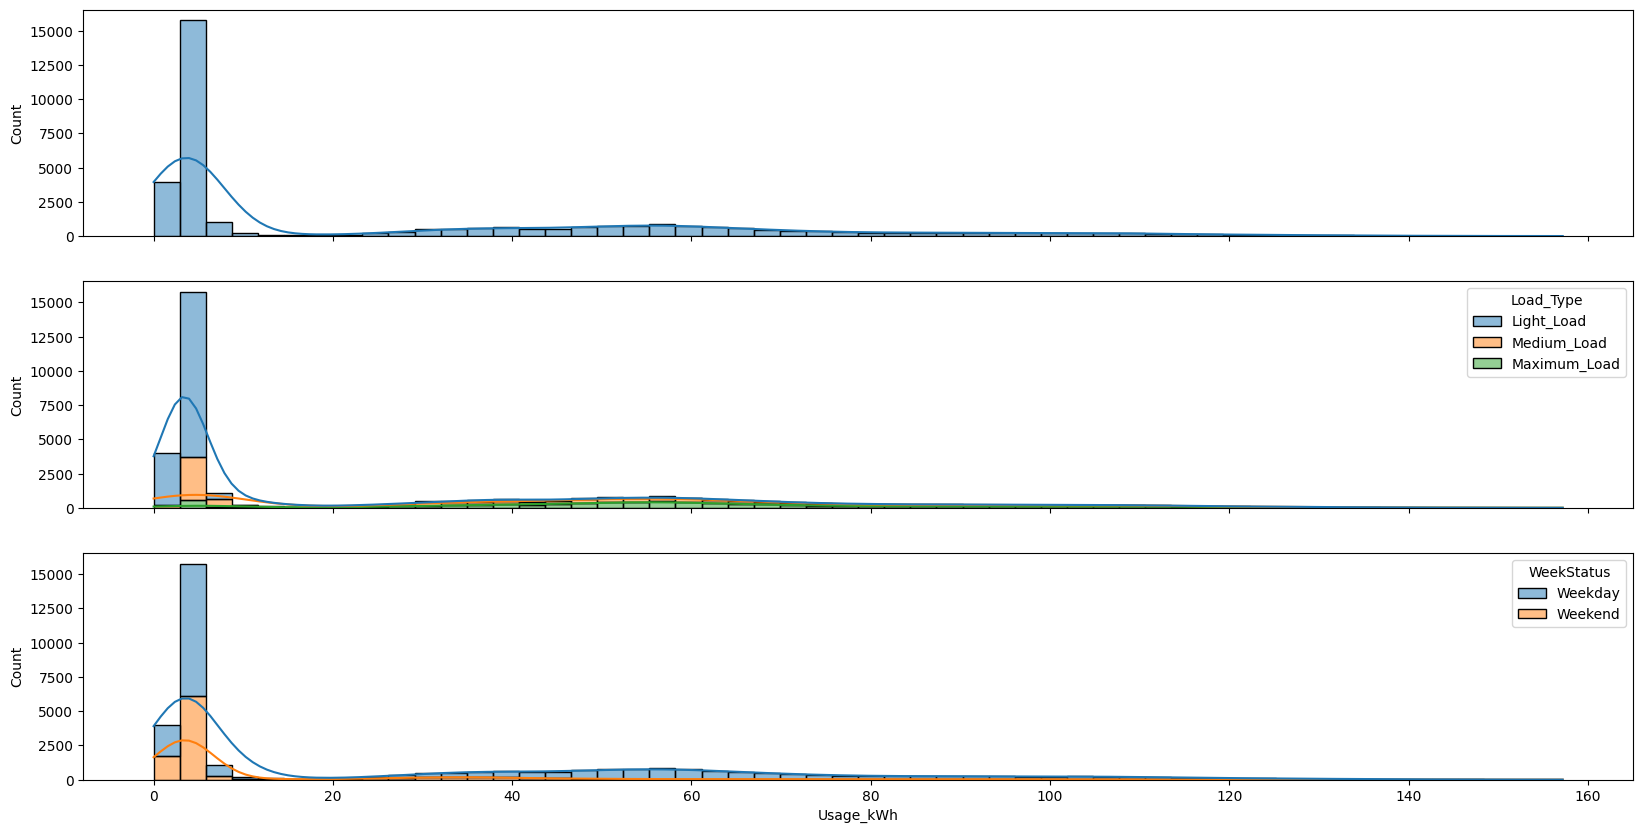

In [12]:
%matplotlib inline
#Visualize the real power usage distributions by categorical features
for col in ['Usage_kWh']:#Num_cols:
    fig, axes = plt.subplots(3, 1, sharex=True, figsize=(20,10))
    sns.histplot(ax=axes[0], data=df1, x=col, kde=True, multiple="stack")
    sns.histplot(ax=axes[1], data=df1, x=col, kde=True, multiple="stack", hue="Load_Type")
    #sns.histplot(ax=axes[2], data=df1, x=col, kde=True, multiple="stack", hue="Day_of_week")
    sns.histplot(ax=axes[2], data=df1, x=col, kde=True, multiple="stack", hue="WeekStatus")
    plt.show()

Again it is very right skewed, so a transformation is needed

In [13]:
#T ake the log( +1 ) of the power usage. 
# Log is good for multiple reasons, it makes modeling impacts additive vs multipliciative, smooths out outliers/extreme values, and is more easy to enforce non-negative values
df1['Usage_kWh_log'] = np.log(1 + df1[col])
df1

,full_date,base_date,month,day,time,dow_occur,Usage_kWh,WeekStatus,Day_of_week,Load_Type,Usage_kWh_log
0,2018-01-01 00:15:00,2018-01-01,1,1,00:15:00,1.0,3.17,Weekday,Monday,Light_Load,1.427916
1,2018-01-01 00:30:00,2018-01-01,1,1,00:30:00,1.0,4.00,Weekday,Monday,Light_Load,1.609438
2,2018-01-01 00:45:00,2018-01-01,1,1,00:45:00,1.0,3.24,Weekday,Monday,Light_Load,1.444563
3,2018-01-01 01:00:00,2018-01-01,1,1,01:00:00,1.0,3.31,Weekday,Monday,Light_Load,1.460938
4,2018-01-01 01:15:00,2018-01-01,1,1,01:15:00,1.0,3.82,Weekday,Monday,Light_Load,1.572774
...,...,...,...,...,...,...,...,...,...,...,...
35035,2018-12-31 23:00:00,2018-12-31,12,31,23:00:00,5.0,3.85,Weekday,Monday,Light_Load,1.578979
35036,2018-12-31 23:15:00,2018-12-31,12,31,23:15:00,5.0,3.74,Weekday,Monday,Light_Load,1.556037
35037,2018-12-31 23:30:00,2018-12-31,12,31,23:30:00,5.0,3.78,Weekday,Monday,Light_Load,1.564441
35038,2018-12-31 23:45:00,2018-12-31,12,31,23:45:00,5.0,3.78,Weekday,Monday,Light_Load,1.564441


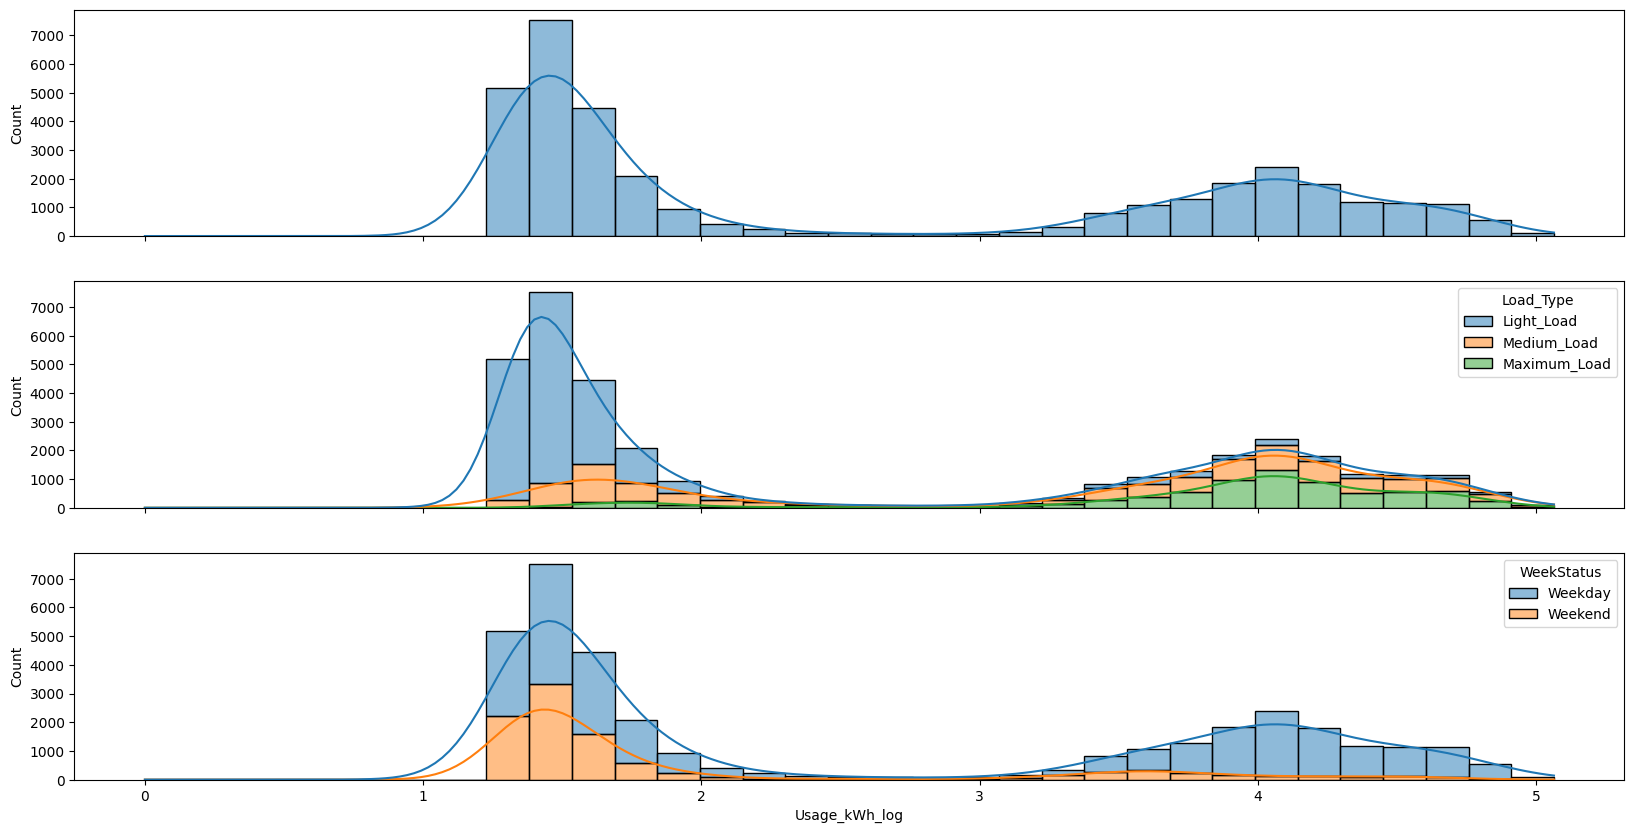

In [14]:
%matplotlib inline
#Try the distributions again with the transformed data
for col in ['Usage_kWh_log']:#Num_cols:
    fig, axes = plt.subplots(3, 1, sharex=True, figsize=(20,10))
    sns.histplot(ax=axes[0], data=df1, x=col, kde=True, multiple="stack")
    sns.histplot(ax=axes[1], data=df1, x=col, kde=True, multiple="stack", hue="Load_Type")
    #sns.histplot(ax=axes[2], data=df1, x=col, kde=True, multiple="stack", hue="Day_of_week")
    sns.histplot(ax=axes[2], data=df1, x=col, kde=True, multiple="stack", hue="WeekStatus")

    plt.show()

We now see the much stronger overlap between categorical features and the bi-modal relationship for real power usage

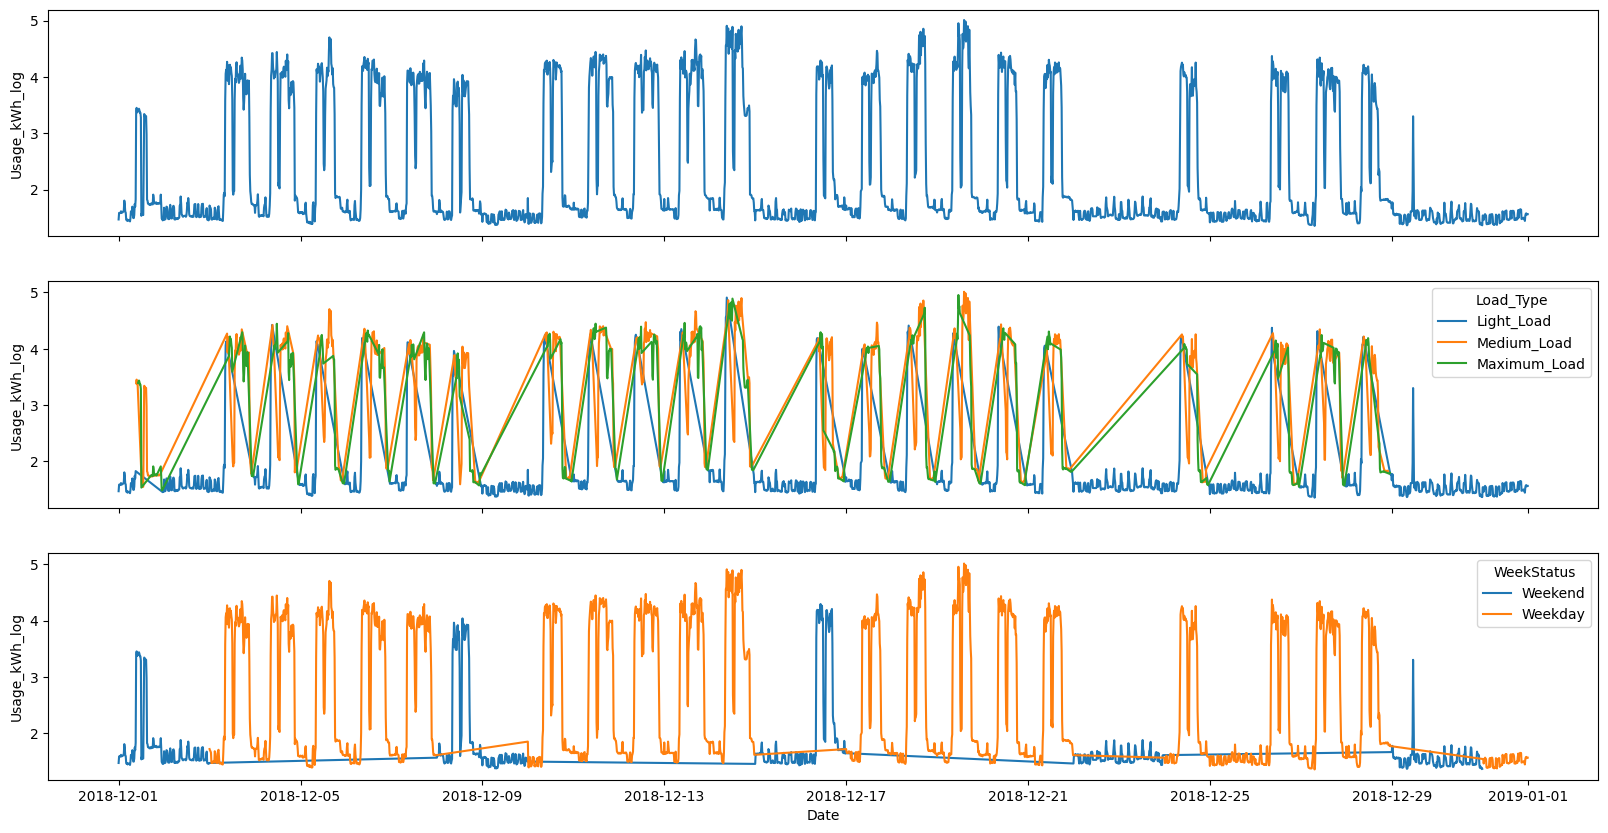

In [15]:
%matplotlib inline
# Visualize the real power usage over time by categorical features
for col in ['Usage_kWh_log']:#Num_cols:
    fig, axes = plt.subplots(3, 1, sharex=True, figsize=(20,10))
    # We use base date (MDY) as full date is too noisy to visualize for trends 
    sns.lineplot(ax=axes[0], data=df1.loc[df1['month'] == 12], x="full_date", y=col)
    sns.lineplot(ax=axes[1], data=df1.loc[df1['month'] == 12], x="full_date", y=col, hue="Load_Type")
    #sns.lineplot(ax=axes[2], data=df1.loc[df1['month'] == 12], x="full_date", y=col, hue="Day_of_week")
    sns.lineplot(ax=axes[2], data=df1.loc[df1['month'] == 12], x="full_date", y=col, hue="WeekStatus")
    plt.xlabel('Date')
    plt.show()

In [131]:
#Derive summary statistics by filtering on categorical field and date with optional breakbout by category field
start_date = '2018-10-01'
end_date = '2018-10-31'
Cat_col = 'Day_of_week'
Cat_Filter = 'Monday'
Eval_var = 'Usage_kWh'
Cat_Break = None#'Load_Type'#
if Cat_Break == None:
    temp = df.loc[(df['base_date'] >= start_date)&(df['base_date'] <= end_date)&(df[Cat_col]== Cat_Filter)][Eval_var]
    print(f'''Zeros: {temp.loc[temp==0].count()}''')
else:
    temp = df.loc[(df['base_date'] >= start_date)&(df['base_date'] <= end_date)&(df[Cat_col]== Cat_Filter)].groupby(Cat_Break)[Eval_var]
temp.describe([0.25,0.75])[['mean', 'min', '25%', '50%', '75%', 'max']]

Zeros: 0


mean     36.908208
min       2.450000
25%       3.012500
50%      13.195000
75%      61.742500
max     135.540000
Name: Usage_kWh, dtype: float64

In [132]:
#Derive summary statistics by filtering on date with optional breakbout by category field
start_date = '2018-02-01'
end_date = '2018-03-01'
var = 'Usage_kWh'
cat_vars = ['Load_Type']#None#
if cat_vars == None:
    temp = df.loc[(df['base_date'] >= start_date)&(df['base_date'] <= end_date)][var]
    print(f'''Zeros: {temp.loc[temp==0].count()}''')
else:
    temp = df.loc[(df['base_date'] >= start_date)&(df['base_date'] <= end_date)].groupby(cat_vars)[var]
temp.describe([0.25,0.75])

,count,mean,std,min,25%,50%,75%,max
Load_Type,,,,,,,,
Light_Load,1664.0,12.516256,22.269033,2.99,3.780,4.390,5.9500,140.29
Maximum_Load,480.0,68.450917,28.024457,5.33,44.065,66.365,88.0375,145.51
Medium_Load,640.0,61.700453,34.379169,3.31,39.455,61.670,84.8450,140.90


In [16]:
#ADF test is used to determine the presence of unit root in the series, and hence helps in understand if the series is stationary or not.
#The null and alternate hypothesis of this test are: Null Hypothesis: The series has a unit root. Alternate Hypothesis: The series has no unit root.
adf_test = adfuller(df1['Usage_kWh'])
# Output the results
print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])
#Reject the null in favor of the alternative

ADF Statistic: -24.281837
p-value: 0.000000


In [17]:
#Test it for the log transformation too
adf_test = adfuller(df1['Usage_kWh_log'])
# Output the results
print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])
#Reject the null in favor of the alternative

ADF Statistic: -23.871690
p-value: 0.000000


In [18]:
#Define major holiday in South Korea for modeling
events = events = pd.DataFrame(holidays.KR(years= [2018,2019]).items())
events = events[[0,1]].rename(columns = {0 : 'ds', 1 : 'holiday'})
events['ds'] = pd.to_datetime(events['ds'])
events = events.dropna()
events['lower_window'] = 0
events['upper_window'] = 1
events.head()

,ds,holiday,lower_window,upper_window
0,2018-01-01,신정연휴,0,1
1,2018-02-16,설날,0,1
2,2018-02-15,설날 전날,0,1
3,2018-02-17,설날 다음날,0,1
4,2018-03-01,삼일절,0,1


In [20]:
# Filter to just needed columns
data = df1[['full_date','Usage_kWh_log']] 
# Rename to accepted fields
data_log = data.rename(columns={'full_date':'ds','Usage_kWh_log':'y'}) 
# Cant have negative power, so set the floor to zero
data_log['floor'] = 0 
# With a negative trend, I just set the cap slightly larger than the largest observation
ceiling = 1.1*data_log['y'].max() 
data_log['cap'] = ceiling

# Define the hyperparameter grid
param_grid = {
    'growth': ['logistic'],
    'holidays': [events],
    'seasonality_mode': ['additive', 'multiplicative'],#2
    'changepoint_prior_scale': [0.001, 0.1, 0.5],#6
    'seasonality_prior_scale': [0.01, 1, 10],#18
    'holidays_prior_scale': [0.01, 1, 10],#54
    'yearly_seasonality' : [False],
    'weekly_seasonality': [True],
    'daily_seasonality': [True],
    'interval_width' : [0.9]
} 


# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
# Store the evaluation metrics for each params here
len_options = len(all_params)
evals = pd.DataFrame()  
indc = 0
# Use cross validation to evaluate all parameters
for params in all_params:
    print(f'{str(100*indc/len_options).format(":.2f")}%')
    # Fit a model using one parameter combination
    m = Prophet(**params).fit(data_log)
    # Cross-validation
    df_cv = cross_validation(m, initial=pd.to_timedelta(int(11*365/12)-1,unit="d"), period=pd.to_timedelta(16,unit="d"), horizon = pd.to_timedelta(31,unit="d"), parallel="processes")
    # Model performance
    df_p = performance_metrics(df_cv, rolling_window=0.1)
    # Extract the performance for a given horizon (31 days)
    df_p_h = df_p[-1:]
    df_p_h['indc'] = indc
    indc = indc + 1 
    # Save model performance metrics
    evals = pd.concat([evals,df_p_h])


0.0%


05:05:49 - cmdstanpy - INFO - Chain [1] start processing
05:05:51 - cmdstanpy - INFO - Chain [1] done processing


1.8518518518518519%


05:11:05 - cmdstanpy - INFO - Chain [1] start processing
05:11:08 - cmdstanpy - INFO - Chain [1] done processing


3.7037037037037037%


05:16:18 - cmdstanpy - INFO - Chain [1] start processing
05:16:19 - cmdstanpy - INFO - Chain [1] done processing


5.555555555555555%


05:21:31 - cmdstanpy - INFO - Chain [1] start processing
05:21:32 - cmdstanpy - INFO - Chain [1] done processing


7.407407407407407%


05:26:40 - cmdstanpy - INFO - Chain [1] start processing
05:26:41 - cmdstanpy - INFO - Chain [1] done processing


9.25925925925926%


05:31:48 - cmdstanpy - INFO - Chain [1] start processing
05:31:50 - cmdstanpy - INFO - Chain [1] done processing


11.11111111111111%


05:37:00 - cmdstanpy - INFO - Chain [1] start processing
05:37:02 - cmdstanpy - INFO - Chain [1] done processing


12.962962962962964%


05:42:05 - cmdstanpy - INFO - Chain [1] start processing
05:42:07 - cmdstanpy - INFO - Chain [1] done processing


14.814814814814815%


05:47:15 - cmdstanpy - INFO - Chain [1] start processing
05:47:18 - cmdstanpy - INFO - Chain [1] done processing


16.666666666666668%


05:52:23 - cmdstanpy - INFO - Chain [1] start processing
05:52:32 - cmdstanpy - INFO - Chain [1] done processing


18.51851851851852%


05:57:45 - cmdstanpy - INFO - Chain [1] start processing
05:57:57 - cmdstanpy - INFO - Chain [1] done processing


20.37037037037037%


06:03:12 - cmdstanpy - INFO - Chain [1] start processing
06:03:22 - cmdstanpy - INFO - Chain [1] done processing


22.22222222222222%


06:08:42 - cmdstanpy - INFO - Chain [1] start processing
06:09:05 - cmdstanpy - INFO - Chain [1] done processing


24.074074074074073%


06:14:13 - cmdstanpy - INFO - Chain [1] start processing
06:14:20 - cmdstanpy - INFO - Chain [1] done processing


25.925925925925927%


06:19:35 - cmdstanpy - INFO - Chain [1] start processing
06:19:48 - cmdstanpy - INFO - Chain [1] done processing


27.77777777777778%


06:24:59 - cmdstanpy - INFO - Chain [1] start processing
06:25:17 - cmdstanpy - INFO - Chain [1] done processing


29.62962962962963%


06:30:32 - cmdstanpy - INFO - Chain [1] start processing
06:30:42 - cmdstanpy - INFO - Chain [1] done processing


31.48148148148148%


06:35:55 - cmdstanpy - INFO - Chain [1] start processing
06:36:07 - cmdstanpy - INFO - Chain [1] done processing


33.333333333333336%


06:41:25 - cmdstanpy - INFO - Chain [1] start processing
06:42:02 - cmdstanpy - INFO - Chain [1] done processing


35.18518518518518%


06:47:32 - cmdstanpy - INFO - Chain [1] start processing
06:48:08 - cmdstanpy - INFO - Chain [1] done processing


37.03703703703704%


06:53:39 - cmdstanpy - INFO - Chain [1] start processing
06:54:03 - cmdstanpy - INFO - Chain [1] done processing


38.888888888888886%


06:59:31 - cmdstanpy - INFO - Chain [1] start processing
06:59:59 - cmdstanpy - INFO - Chain [1] done processing


40.74074074074074%


07:05:22 - cmdstanpy - INFO - Chain [1] start processing
07:06:02 - cmdstanpy - INFO - Chain [1] done processing


42.592592592592595%


07:11:30 - cmdstanpy - INFO - Chain [1] start processing
07:11:52 - cmdstanpy - INFO - Chain [1] done processing


44.44444444444444%


07:17:22 - cmdstanpy - INFO - Chain [1] start processing
07:17:53 - cmdstanpy - INFO - Chain [1] done processing


46.2962962962963%


07:23:24 - cmdstanpy - INFO - Chain [1] start processing
07:23:46 - cmdstanpy - INFO - Chain [1] done processing


48.148148148148145%


07:29:07 - cmdstanpy - INFO - Chain [1] start processing
07:29:53 - cmdstanpy - INFO - Chain [1] done processing


50.0%


07:35:20 - cmdstanpy - INFO - Chain [1] start processing
07:35:22 - cmdstanpy - INFO - Chain [1] done processing


51.851851851851855%


07:40:34 - cmdstanpy - INFO - Chain [1] start processing
07:40:36 - cmdstanpy - INFO - Chain [1] done processing


53.7037037037037%


07:45:53 - cmdstanpy - INFO - Chain [1] start processing
07:45:55 - cmdstanpy - INFO - Chain [1] done processing


55.55555555555556%


07:51:09 - cmdstanpy - INFO - Chain [1] start processing
07:51:11 - cmdstanpy - INFO - Chain [1] done processing


57.407407407407405%


07:56:29 - cmdstanpy - INFO - Chain [1] start processing
07:56:31 - cmdstanpy - INFO - Chain [1] done processing


59.25925925925926%


08:01:42 - cmdstanpy - INFO - Chain [1] start processing
08:01:44 - cmdstanpy - INFO - Chain [1] done processing


61.111111111111114%


08:06:50 - cmdstanpy - INFO - Chain [1] start processing
08:06:52 - cmdstanpy - INFO - Chain [1] done processing


62.96296296296296%


08:11:56 - cmdstanpy - INFO - Chain [1] start processing
08:11:58 - cmdstanpy - INFO - Chain [1] done processing


64.81481481481481%


08:17:02 - cmdstanpy - INFO - Chain [1] start processing
08:17:04 - cmdstanpy - INFO - Chain [1] done processing


66.66666666666667%


08:22:08 - cmdstanpy - INFO - Chain [1] start processing
08:22:34 - cmdstanpy - INFO - Chain [1] done processing


68.51851851851852%


08:27:50 - cmdstanpy - INFO - Chain [1] start processing
08:28:06 - cmdstanpy - INFO - Chain [1] done processing


70.37037037037037%


08:33:16 - cmdstanpy - INFO - Chain [1] start processing
08:33:28 - cmdstanpy - INFO - Chain [1] done processing


72.22222222222223%


08:38:39 - cmdstanpy - INFO - Chain [1] start processing
08:39:00 - cmdstanpy - INFO - Chain [1] done processing


74.07407407407408%


08:44:10 - cmdstanpy - INFO - Chain [1] start processing
08:44:21 - cmdstanpy - INFO - Chain [1] done processing


75.92592592592592%


08:49:30 - cmdstanpy - INFO - Chain [1] start processing
08:49:45 - cmdstanpy - INFO - Chain [1] done processing


77.77777777777777%


08:55:01 - cmdstanpy - INFO - Chain [1] start processing
08:55:22 - cmdstanpy - INFO - Chain [1] done processing


79.62962962962963%


09:00:32 - cmdstanpy - INFO - Chain [1] start processing
09:00:47 - cmdstanpy - INFO - Chain [1] done processing


81.48148148148148%


09:05:57 - cmdstanpy - INFO - Chain [1] start processing
09:06:08 - cmdstanpy - INFO - Chain [1] done processing


83.33333333333333%


09:11:20 - cmdstanpy - INFO - Chain [1] start processing
09:11:55 - cmdstanpy - INFO - Chain [1] done processing


85.18518518518519%


09:17:25 - cmdstanpy - INFO - Chain [1] start processing
09:18:01 - cmdstanpy - INFO - Chain [1] done processing


87.03703703703704%


09:23:31 - cmdstanpy - INFO - Chain [1] start processing
09:24:10 - cmdstanpy - INFO - Chain [1] done processing


88.88888888888889%


09:29:44 - cmdstanpy - INFO - Chain [1] start processing
09:30:21 - cmdstanpy - INFO - Chain [1] done processing


90.74074074074075%


09:36:01 - cmdstanpy - INFO - Chain [1] start processing
09:36:41 - cmdstanpy - INFO - Chain [1] done processing


92.5925925925926%


09:42:13 - cmdstanpy - INFO - Chain [1] start processing
09:42:43 - cmdstanpy - INFO - Chain [1] done processing


94.44444444444444%


09:48:14 - cmdstanpy - INFO - Chain [1] start processing
09:48:44 - cmdstanpy - INFO - Chain [1] done processing


96.29629629629629%


09:54:29 - cmdstanpy - INFO - Chain [1] start processing
09:55:09 - cmdstanpy - INFO - Chain [1] done processing


98.14814814814815%


10:00:49 - cmdstanpy - INFO - Chain [1] start processing
10:01:16 - cmdstanpy - INFO - Chain [1] done processing


{'growth': 'logistic', 'holidays':            ds     holiday  lower_window  upper_window
0  2018-01-01        신정연휴             0             1
1  2018-02-16          설날             0             1
2  2018-02-15       설날 전날             0             1
3  2018-02-17      설날 다음날             0             1
4  2018-03-01         삼일절             0             1
5  2018-05-22      부처님오신날             0             1
6  2018-05-05        어린이날             0             1
7  2018-06-06         현충일             0             1
8  2018-08-15         광복절             0             1
9  2018-10-03         개천절             0             1
10 2018-10-09         한글날             0             1
11 2018-09-24          추석             0             1
12 2018-09-23       추석 전날             0             1
13 2018-09-25      추석 다음날             0             1
14 2018-12-25       기독탄신일             0             1
15 2018-06-13       지방선거일             0             1
16 2018-05-07  어린이날 대체 휴일             0        

In [50]:
# Save evaluation metrics
evals.to_csv("C:/Users/erice/OneDrive/Desktop/Data Society Assessment/Model_Evaluations.csv", index = True)  
# Tuning results
best_params = all_params[int(evals.iloc[np.argmin(evals['rmse'])]['indc'])]
# Best parameters
print(best_params)
# Train model using best parameters
best_model_log = Prophet(**best_params)
# Fit the model on the training dataset
best_model_log.fit(data_log)
# Cross validation
best_model_log_cv = cross_validation(best_model_log, initial=pd.to_timedelta(int(11*365/12)-1,unit="d"), period=pd.to_timedelta(16,unit="d"), horizon = pd.to_timedelta(31,unit="d"), parallel="processes")
# Model performance metrics
best_model_log_p = performance_metrics(best_model_log_cv, rolling_window=0.1)
# Create a future DataFrame for 31 days
best_model_log_future = best_model_log.make_future_dataframe(periods=31*60*24, freq='min')   

{'growth': 'logistic', 'holidays':            ds     holiday  lower_window  upper_window
0  2018-01-01        신정연휴             0             1
1  2018-02-16          설날             0             1
2  2018-02-15       설날 전날             0             1
3  2018-02-17      설날 다음날             0             1
4  2018-03-01         삼일절             0             1
5  2018-05-22      부처님오신날             0             1
6  2018-05-05        어린이날             0             1
7  2018-06-06         현충일             0             1
8  2018-08-15         광복절             0             1
9  2018-10-03         개천절             0             1
10 2018-10-09         한글날             0             1
11 2018-09-24          추석             0             1
12 2018-09-23       추석 전날             0             1
13 2018-09-25      추석 다음날             0             1
14 2018-12-25       기독탄신일             0             1
15 2018-06-13       지방선거일             0             1
16 2018-05-07  어린이날 대체 휴일             0        

12:34:30 - cmdstanpy - INFO - Chain [1] start processing
12:34:32 - cmdstanpy - INFO - Chain [1] done processing


In [23]:
# Filter to 15 min intervals
best_model_log_future = best_model_log_future.loc[best_model_log_future['ds'].dt.minute.isin([0, 15, 30, 45])] 
# Set floor
best_model_log_future['floor'] = 0
# Set cap
best_model_log_future['cap'] = ceiling
# Predict the target for the given time windows
best_model_log_future = best_model_log.predict(best_model_log_future)     

In [47]:
# Join on the prediction to the actual values for the fulltime window and extension
best_model_df = best_model_log_future.merge(df1[['full_date','Usage_kWh','Usage_kWh_log']].rename(columns={'full_date':'ds','Usage_kWh':'kWH','Usage_kWh_log':'y'}) ,how='left',on='ds')
# Convert model predictions to kWHs again
best_model_df['kWH_hat'] = best_model_df['yhat'].apply(lambda x: math.exp(x)-1)
# Derive the difference in model output and actuals in kWH
best_model_df['Error'] = (best_model_df['kWH_hat']-best_model_df['kWH'])
# Derive the difference in model output and actuals
best_model_df['Error_log'] = (best_model_df['yhat']-best_model_df['y'])
# Build time variables
best_model_df['full_date'] = pd.to_datetime(best_model_df['ds'])
best_model_df['base_date'] = pd.to_datetime(best_model_df['full_date'].dt.strftime('%Y-%m-%d'))
best_model_df['Day_of_week'] = best_model_df['full_date'].dt.strftime('%A')
best_model_df['day'] = best_model_df['full_date'].dt.day.astype(int)
best_model_df['month'] = best_model_df['full_date'].dt.month.astype(int)
best_model_df['year'] = best_model_df['full_date'].dt.year.astype(int)
best_model_df['time'] = best_model_df['full_date'].dt.time
for i in best_model_df.index:
    best_model_df.loc[i,'dow_occur'] = int(dow_occur(best_model_df.loc[i,'day']))
    if best_model_df.loc[i,'Day_of_week'] in ['Saturday', 'Sunday']:
        best_model_df.loc[i,'WeekStatus'] = 'Weekend'
    else:
        best_model_df.loc[i,'WeekStatus'] = 'Weekday'

# Manually calculate RMSE for Dec in kWH
Best_RMSE_Manual = ((best_model_df.loc[(best_model_df['base_date']>= '2018-12-01')&(best_model_df['base_date']<= '2018-12-31')]['Error']**2).mean())**(1/2)
# Manually calculate RMSE for Dec in model outputs 
Best_RMSE_Manual_log = ((best_model_df.loc[(best_model_df['base_date']>= '2018-12-01')&(best_model_df['base_date']<= '2018-12-31')]['Error_log']**2).mean())**(1/2)
# Calculate kWH expectation for Jan'19
Best_Jan19 = best_model_df.loc[(best_model_df['base_date']>= '2019-01-01')&(best_model_df['base_date']<= '2019-01-31')]['kWH_hat'].sum()
# Calculate kWH actuals for Jan'18
Best_Jan18 = best_model_df.loc[(best_model_df['base_date']>= '2018-01-01')&(best_model_df['base_date']<= '2018-01-31')]['kWH'].sum()
# Calculate kWH actuals for Dec'18
Best_Dec18 = best_model_df.loc[(best_model_df['base_date']>= '2018-12-01')&(best_model_df['base_date']<= '2018-12-31')]['kWH'].sum()
# Show results
print(f'kWH RMSE: {Best_RMSE_Manual}')
print(f'log(kWH+1) RMSE: {Best_RMSE_Manual_log}')
print(f"Jan'19: {Best_Jan19}")
print(f'''Y/Y: {Best_Jan19-Best_Jan18}''')
print(f'''M/M: {Best_Jan19-Best_Dec18}''')

kWH RMSE: 20.001955697997452
log(kWH+1) RMSE: 0.7775076846703587
Jan'19: 45372.67369303681
Y/Y: -80865.61630696317
M/M: -14064.106306963185


1.0586700684220012
1.882534864800463


<Figure size 2000x1000 with 0 Axes>

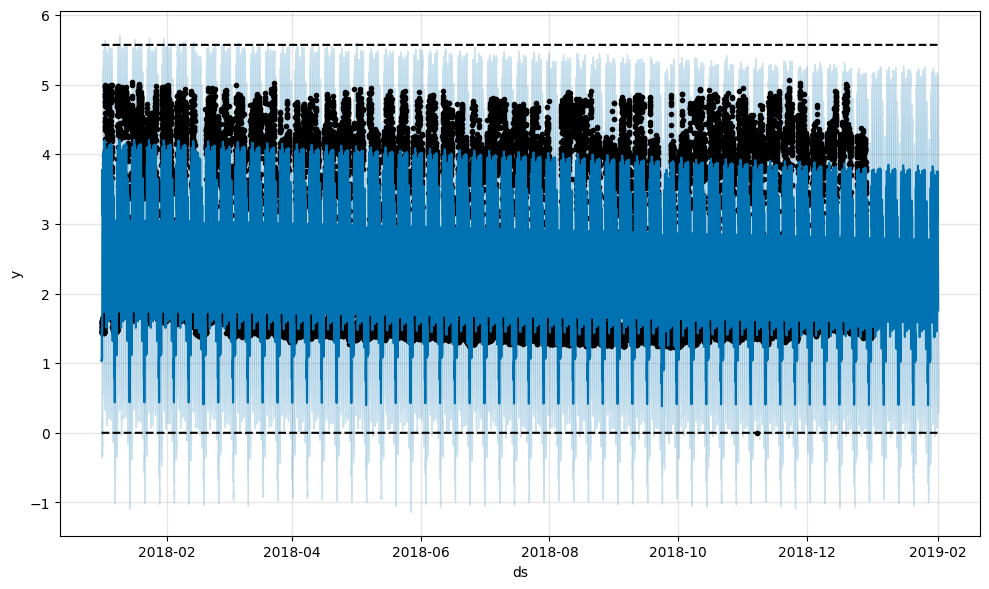

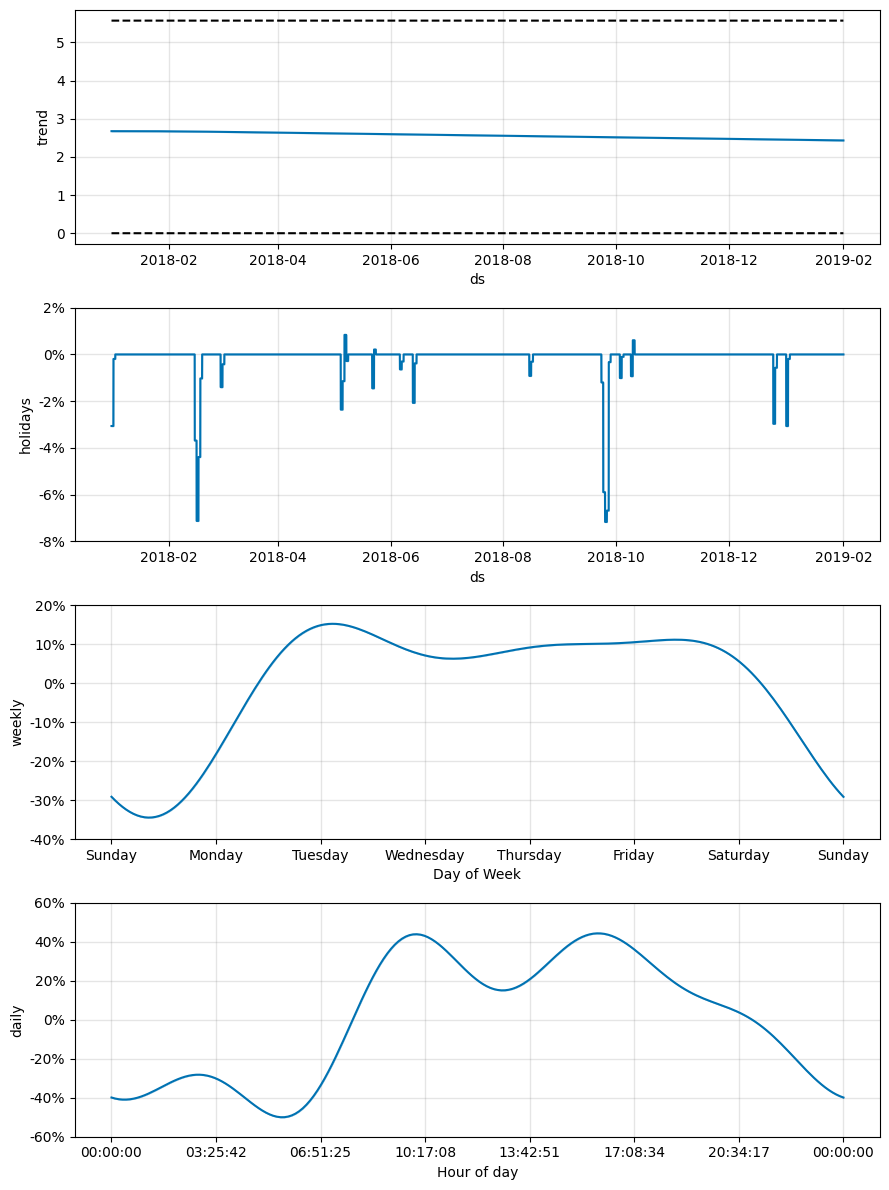

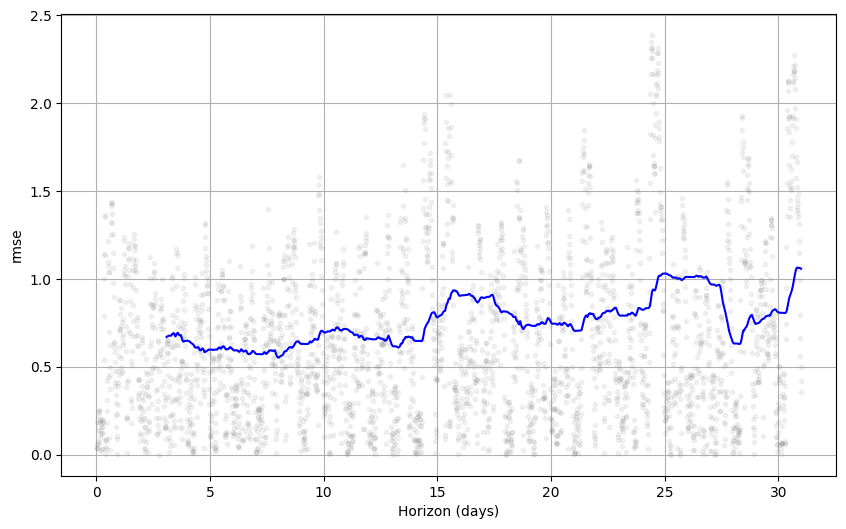

In [28]:
plt.figure(figsize=(20,10))      
# Plot the forecast
plot(best_model_log, best_model_log_future)              
# Plot the forecast components 
plot_components(best_model_log, best_model_log_future)    
#Calculate the base level model performance
df_cv = cross_validation(best_model_log, initial=pd.to_timedelta(int(11*365/12)-1,unit="d"), period=pd.to_timedelta(16,unit="d"), horizon = pd.to_timedelta(31,unit="d"), parallel="processes")
# Model performance
df_p = performance_metrics(df_cv, rolling_window=0.1)
# Plot the root mean squared error with a horizon of 31 days and a 10% ratio of predictions
fig = plot_cross_validation_metric(df_cv, metric='rmse')
#rmse = df_p.iloc[-1,:]['rmse']
#print(rmse)
#print(math.exp(rmse)-1)
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

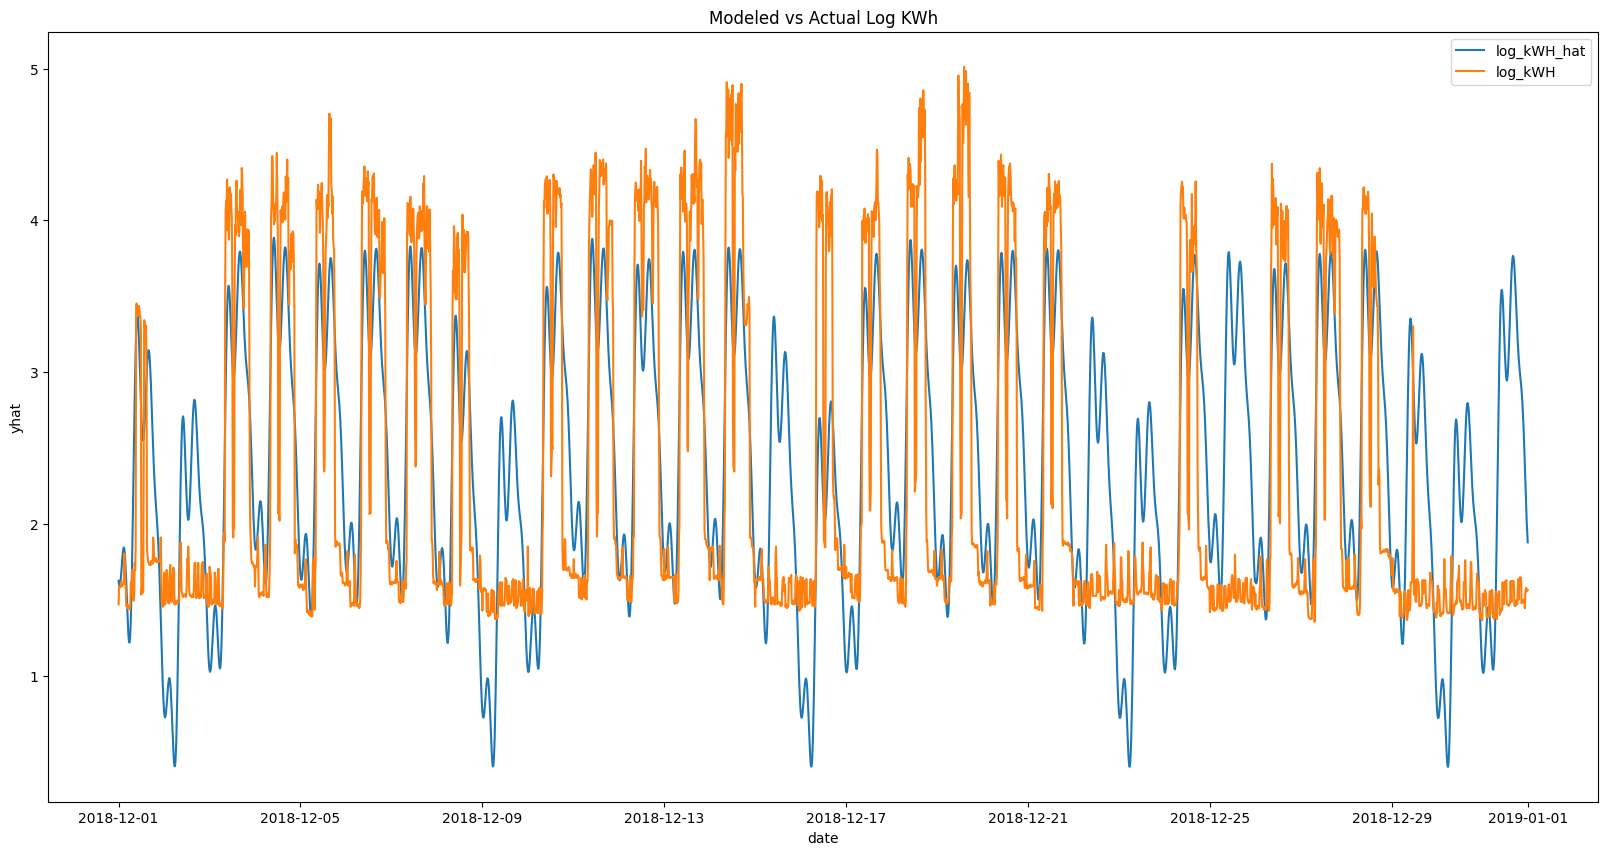

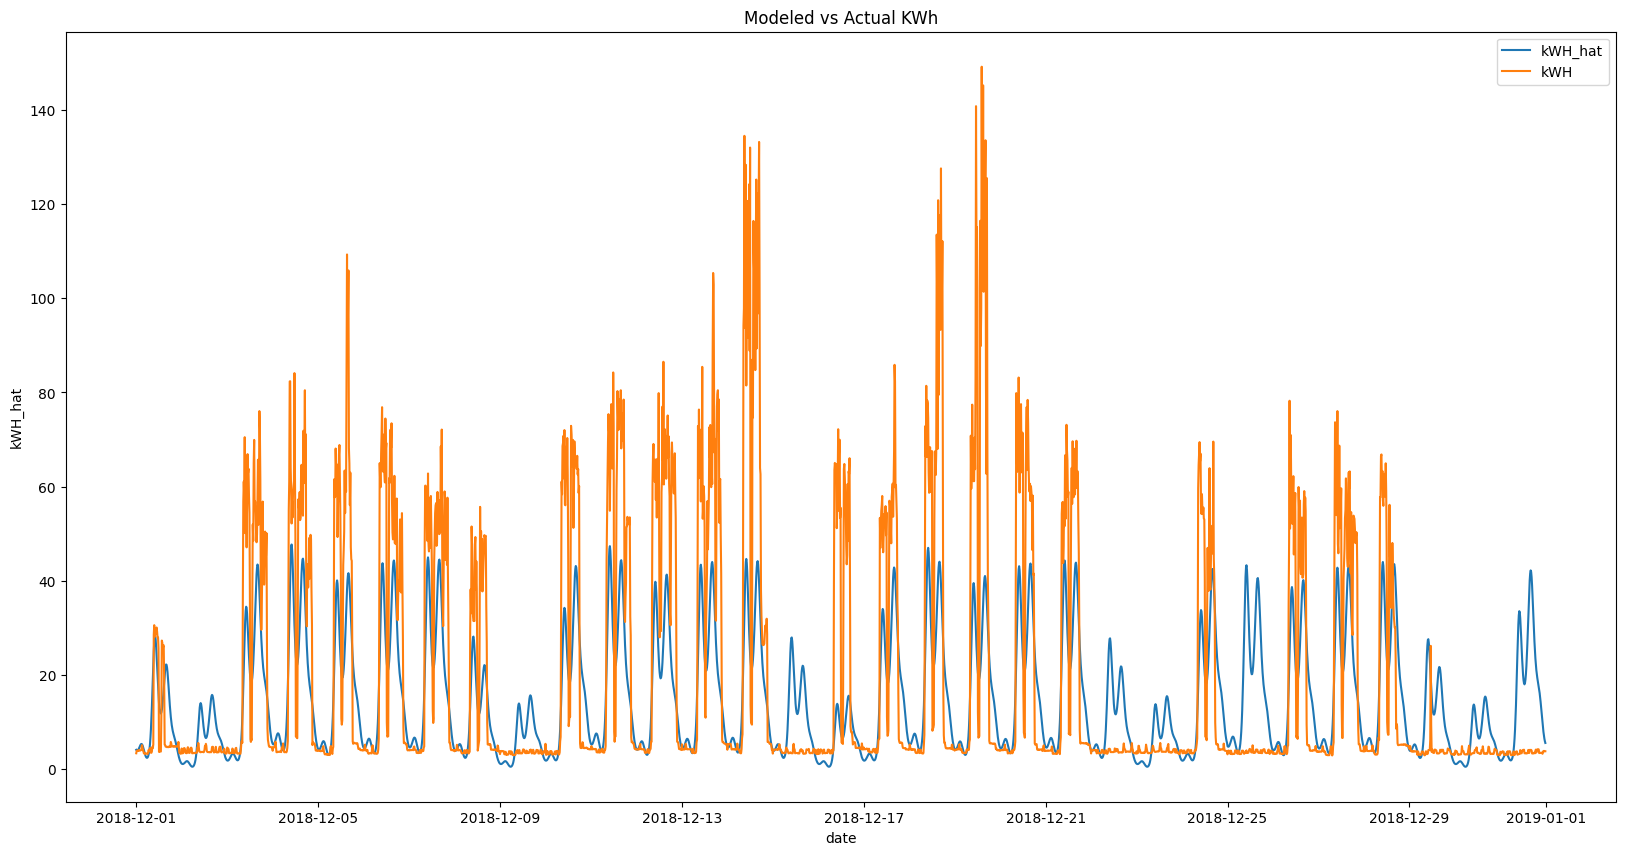

In [29]:
# Plot actuals and predictions for both kWH and log(kWH + 1)
plt.figure(figsize=(20,10)) 
sns.lineplot(data=best_model_df.loc[best_model_df['month'] == 12], x="ds", y="yhat",label='log_kWH_hat')
sns.lineplot(data=best_model_df.loc[best_model_df['month'] == 12], x="ds", y='y',label='log_kWH')
plt.xlabel('date')
plt.title('Modeled vs Actual Log KWh')
plt.legend()
plt.show
plt.figure(figsize=(20,10)) 
sns.lineplot(data=best_model_df.loc[best_model_df['month'] == 12], x="ds", y="kWH_hat",label='kWH_hat')
sns.lineplot(data=best_model_df.loc[best_model_df['month'] == 12], x="ds", y='kWH',label='kWH')
plt.xlabel('date')
plt.title('Modeled vs Actual KWh')
plt.legend()
plt.show

In [42]:
#Derive summary statistics by filtering on categorical field and date with optional breakbout by category field
start_date = '2018-10-01'
end_date = '2018-10-31'
Cat_col = 'Day_of_week'
Cat_Filter = 'Monday'
Eval_var = 'kWH'
Cat_Break = None#'Load_Type'#
if Cat_Break == None:
    temp = best_model_df.loc[(best_model_df['base_date'] >= start_date)&(df['base_date'] <= end_date)&(best_model_df[Cat_col]== Cat_Filter)][Eval_var]
    print(f'''Zeros: {temp.loc[temp==0].count()}''')
else:
    temp = best_model_df.loc[(best_model_df['base_date'] >= start_date)&(best_model_df['base_date'] <= end_date)&(df[Cat_col]== Cat_Filter)].groupby(Cat_Break)[Eval_var]
temp.describe([0.25,0.75])[['mean', 'min', '25%', '50%', '75%', 'max']]

Zeros: 0


mean     36.908208
min       2.450000
25%       3.012500
50%      13.195000
75%      61.742500
max     135.540000
Name: kWH, dtype: float64